In [14]:
# 📚 Imports
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [15]:
# 📥 Load CSV Files
nodes_df = pd.read_csv("nodes.csv")
edges_df = pd.read_csv("edges.csv")

print("✅ Nodes loaded:", len(nodes_df))
print("✅ Edges loaded:", len(edges_df))

✅ Nodes loaded: 20
✅ Edges loaded: 50


In [17]:
# 🧱 Build Directed Graph
G = nx.DiGraph()

# Add nodes with attributes
for _, row in nodes_df.iterrows():
    G.add_node(row['node_id'], type=row['node_type'], location=row['location'])

# Add edges with attributes + estimated CO₂
for _, row in edges_df.iterrows():
    co2_kg = round(row['distance_km'] * 0.13, 2)  # Approximation
    G.add_edge(row['from_node'], row['to_node'],
               transport=row['transport_mode'],
               distance=row['distance_km'],
               delay=row['avg_delay_hr'],
               co2_kg=co2_kg)

In [18]:
# 📊 Basic Graph Stats
print("Number of Nodes:", G.number_of_nodes())
print("Number of Edges:", G.number_of_edges())

Number of Nodes: 20
Number of Edges: 44


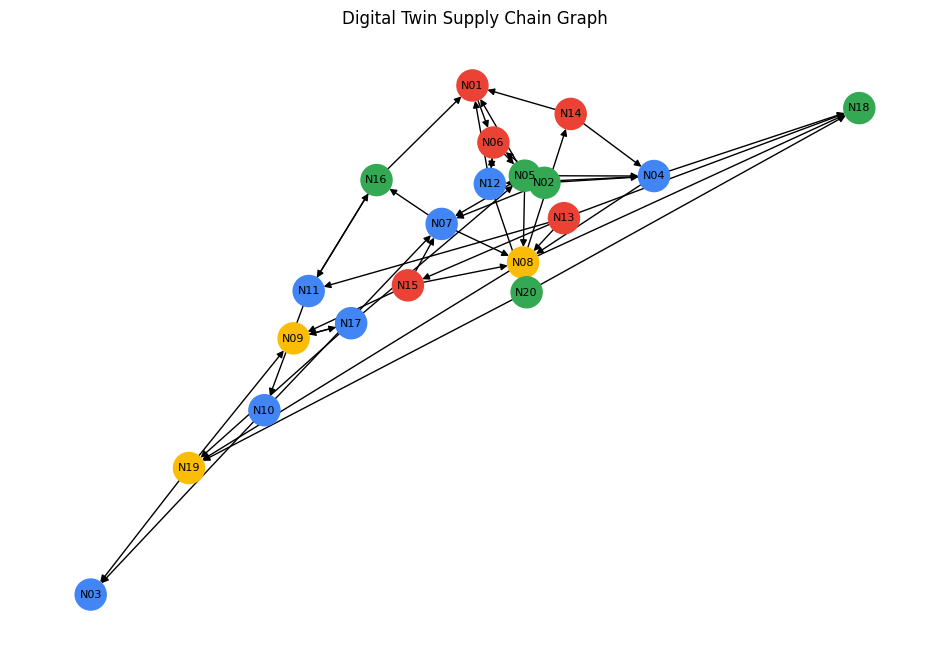

In [19]:
# 📍 Visualize the Graph (simplified)
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)

node_colors = ["#34a853" if G.nodes[n]['type'] == 'Warehouse' else
               "#4285f4" if G.nodes[n]['type'] == 'Supplier' else
               "#fbbc05" if G.nodes[n]['type'] == 'Port' else "#ea4335"
               for n in G.nodes()]

nx.draw_networkx(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=8)
plt.title("Digital Twin Supply Chain Graph")
plt.axis('off')
plt.show()

# 📈 Emissions Predictor – Regression Model

This notebook trains a regression model to estimate CO₂ emissions per shipment.

In [20]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [21]:
# 📥 Load shipment and edge data
shipments = pd.read_csv("shipments.csv")
edges = pd.read_csv("edges.csv")

# Merge on source/target as route identifier (simplified join)
merged = shipments.merge(edges, left_on=["source", "target"], right_on=["from_node", "to_node"], how="left")

# Add congestion as a random factor (simulated for demo)
merged["congestion"] = np.random.choice(["Low", "Medium", "High"], size=len(merged))

# Simulate CO2 emissions (target variable)
merged["co2_kg"] = merged["distance_km"] * np.random.uniform(0.11, 0.15, size=len(merged))
merged = merged.dropna(subset=["co2_kg"])

In [22]:
# 🎯 Feature Engineering
le_vehicle = LabelEncoder()
le_congestion = LabelEncoder()

merged["vehicle_encoded"] = le_vehicle.fit_transform(merged["vehicle_type"])
merged["congestion_encoded"] = le_congestion.fit_transform(merged["congestion"])

X = merged[["distance_km", "vehicle_encoded", "congestion_encoded"]]
y = merged["co2_kg"]
merged = merged.dropna(subset=["co2_kg"])



In [23]:
# 🔍 Train/Test Split and Model Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [25]:
# 📊 Evaluation
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, predictions)
print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 7.859393857788948
MAE: 5.8748524565923965
